In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [4]:
def run_command(c):
    with sqlite.connect('chinhook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [5]:
def show_tables():
    q = """
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type in ('table', 'view')
        """
    return run_query(q)

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Find which genres sell best in USA

- Write query that returns each genre, number of track sold, and percentages in USA

- Plot the data

In [7]:
q1 = """
    WITH total_usa_sold AS
        (
        SELECT 
            il.invoice_line_id
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
        WHERE c.country = "USA"
        )
    SELECT 
        g.name,
        COUNT(il.invoice_line_id) genre_sales,
        CAST(COUNT(il.invoice_line_id) AS FLOAT) / (SELECT COUNT(invoice_line_id) FROM total_usa_sold) percentage
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    WHERE c.country = "USA"
    GROUP BY 1
    ORDER BY genre_sales DESC
    """
run_query(q1)

,name,genre_sales,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


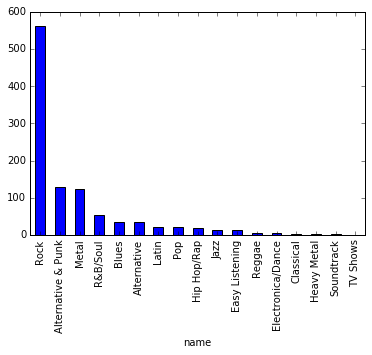

In [8]:
genre_USA = run_query(q1)
genre_USA.set_index("name", inplace=True, drop=True)

genre_USA['genre_sales'].plot.bar()

In [9]:
employee_sales_q = """
                    SELECT
                        e.last_name || ', ' || e.first_name name,
                        e.hire_date,
                        SUM(i.total) total_sales
                    FROM employee e
                    INNER JOIN customer c ON c.support_rep_id = e.employee_id
                    INNER JOIN invoice i ON i.customer_id = c.customer_id
                    GROUP BY 1
                    ORDER BY total_sales DESC
                    """
run_query(employee_sales_q)

,name,hire_date,total_sales
0,"Peacock, Jane",2017-04-01 00:00:00,1731.51
1,"Park, Margaret",2017-05-03 00:00:00,1584.00
2,"Johnson, Steve",2017-10-17 00:00:00,1393.92


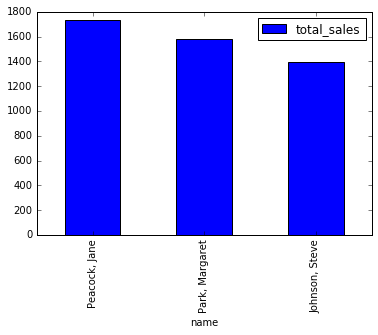

In [10]:
employee_sales = run_query(employee_sales_q)

employee_sales.set_index('name', inplace=True, drop=True)

employee_sales.plot.bar()

The difference in sales corresponds to the difference in hiring dates

# Customers from different countries

In [11]:
country_stats = """
                    
                    SELECT
                        COUNT(c.customer_id),
                        c.country
                    FROM customer c
                    GROUP BY c.country
                    
                """
run_query(country_stats)

,COUNT(c.customer_id),country
0,1,Argentina
1,1,Australia
2,1,Austria
3,1,Belgium
4,5,Brazil
5,8,Canada
6,1,Chile
7,2,Czech Republic
8,1,Denmark
9,1,Finland


In [12]:
country_stats = """
                WITH
                    country_customers AS
                        (
                        SELECT
                            COUNT(customer_id) customers,
                            c.country
                        FROM customer c
                        GROUP BY c.country
                        ),
                    
                    country_tot_sales AS
                        (
                        SELECT
                            c.country,
                            SUM(i.total) total_sales
                        FROM customer c
                        INNER JOIN invoice i ON i.customer_id = c.customer_id
                        GROUP BY c.country
                        ),
                    
                    country_orders AS
                        (
                        SELECT
                            c.country,
                            COUNT(i.invoice_id) num_orders
                        FROM customer c
                        INNER JOIN invoice i ON i.customer_id = c.customer_id
                        GROUP BY c.country
                        ),
                        
                    all_together AS
                        (
                        SELECT
                            cc.country,
                            cc.customers,
                            cts.total_sales,
                            cts.total_sales / cc.customers av_per_customer,
                            cts.total_sales / co.num_orders av_per_order
                        FROM country_customers cc
                        INNER JOIN country_tot_sales cts ON cts.country = cc.country
                        INNER JOIN country_orders co ON co.country = cc.country
                        ),
                    
                    other_cat AS
                        (
                        SELECT
                            at.*,
                            CASE
                                WHEN at.customers < 2 THEN 'OTHER'
                                ELSE at.country
                            end AS country_name
                        FROM all_together at
                        ),
                    
                    final_list AS
                        (
                        SELECT
                            oc.country_name,
                            SUM(oc.customers),
                            SUM(oc.total_sales),
                            SUM(oc.av_per_customer),
                            SUM(oc.av_per_order)
                        FROM other_cat OC
                        GROUP BY country_name
                        )
                        
                        
                SELECT * from final_list
                    
                """
run_query(country_stats)

,country_name,SUM(oc.customers),SUM(oc.total_sales),SUM(oc.av_per_customer),SUM(oc.av_per_order)
0,Brazil,5,427.68,85.536000,7.011148
1,Canada,8,535.59,66.948750,7.047237
2,Czech Republic,2,273.24,136.620000,9.108000
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,India,2,183.15,91.575000,8.721429
6,OTHER,15,1094.94,1094.940000,111.676066
7,Portugal,2,185.13,92.565000,6.383793
8,USA,13,1040.49,80.037692,7.942672
9,United Kingdom,3,245.52,81.840000,8.768571


In [13]:
country_stats = """
                WITH
                    country_customers AS
                        (
                        SELECT
                            COUNT(customer_id) customers,
                            c.country
                        FROM customer c
                        GROUP BY c.country
                        ),
                        
                    country_relabel AS
                        (
                        SELECT
                            c.customer_id,
                            CASE
                                WHEN (
                                        SELECT customers FROM country_customers cc
                                        WHERE cc.country = c.country
                                    ) < 2 THEN 'OTHER'
                                ELSE c.country
                            END as country_name
                        FROM customer c
                        ),
                    
                    all_data AS
                        (
                        SELECT
                            cr.country_name,
                            COUNT(DISTINCT(cr.customer_id)) customers,
                            SUM(i.total) total_sales,
                            SUM(i.total) / COUNT(i.invoice_id) av_order,
                            SUM(i.total) / COUNT(DISTINCT(cr.customer_id)) per_customer
                        FROM country_relabel cr
                        INNER JOIN invoice i ON i.customer_id = cr.customer_id
                        GROUP BY country_name
                        ORDER BY total_sales DESC
                        )
                        
                    SELECT
                        country_name,
                        customers,
                        total_sales,
                        av_order,
                        per_customer
                    FROM
                        (
                        SELECT
                            ad.*,
                            CASE
                                WHEN ad.country_name = 'OTHER' THEN 1
                                ELSE 0
                            END AS sort
                        FROM all_data ad    
                        )
                    ORDER BY sort ASC
                    """
run_query(country_stats)

,country_name,customers,total_sales,av_order,per_customer
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,OTHER,15,1094.94,7.448571,72.996000


In [14]:
country_summary = run_query(country_stats)
country_summary.set_index('country_name', inplace=True, drop=True)


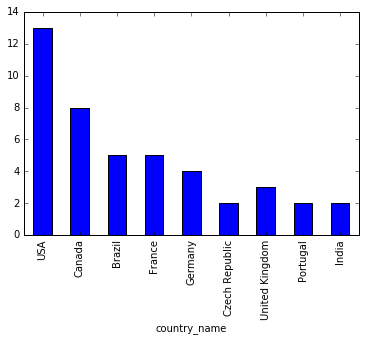

In [15]:
country_summary['customers'].iloc[:-1].plot.bar()

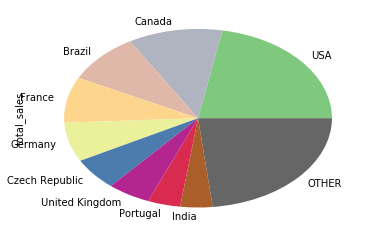

In [16]:
country_summary['total_sales'].plot.pie(colormap=plt.cm.Accent, wedgeprops={'linewidth':0})

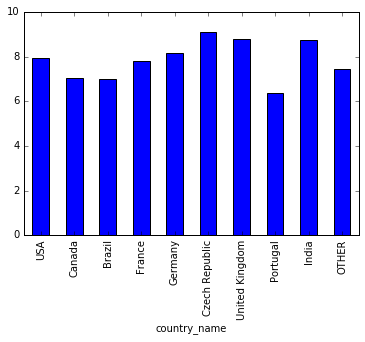

In [17]:
country_summary['av_order'].plot.bar()

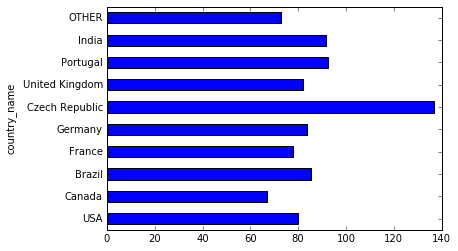

In [18]:
country_summary['per_customer'].plot.barh()

# Albums vs individual tracks

In [44]:
album_v_tracks_q = """ 
                    WITH
                        invoice_album AS
                            (
                            SELECT
                                i.invoice_id,
                                t.album_id
                            FROM invoice i
                            INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
                            INNER JOIN track t ON t.track_id = il.track_id
                            GROUP BY i.invoice_id, t.album_id
                            ),
                        
                        album_songs AS
                            (
                            SELECT
                                a.album_id,
                                t.track_id
                            FROM track t
                            INNER JOIN album a ON a.album_id = t.album_id
                            ),
                            
                        data AS
                            (
                            SELECT
                                ia.invoice_id,
                                ia.album_id,
                                CASE
                                    WHEN

                                            (
                                            SELECT il.track_id FROM invoice_line il
                                            WHERE il.invoice_id = ia.invoice_id
                                            EXCEPT
                                            SELECT als.track_id FROM album_songs als
                                            WHERE als.album_id = ia.album_id
                                            ) IS NULL

                                            AND

                                            (
                                            SELECT als.track_id FROM album_songs als
                                            WHERE als.album_id = ia.album_id
                                            EXCEPT
                                            SELECT il.track_id FROM invoice_line il
                                            WHERE il.invoice_id = ia.invoice_id
                                            ) IS NULL

                                    THEN 0
                                    ELSE 1
                                END AS single_purchase
                            FROM invoice_album ia
                            ),
                            
                        final_invoice AS
                            (
                            SELECT
                                d.invoice_id,
                                SUM(d.single_purchase) single_purchase
                            FROM data d
                            GROUP BY 1
                            ),
                        
                        label_purchases AS
                            (
                            SELECT
                                fi.invoice_id,
                                fi.single_purchase,
                                CASE
                                    WHEN fi.single_purchase = 0
                                    THEN 'Album purchase'
                                    ELSE 'Single purchase(s)'
                                END AS purchase_type
                            FROM final_invoice fi
                            )
                        
                    SELECT
                        purchase_type,
                        COUNT(invoice_id),
                        CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice)
                    FROM label_purchases
                    GROUP BY purchase_type
                    """
run_query(album_v_tracks_q)

,purchase_type,COUNT(invoice_id),CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice)
0,Album purchase,114,0.185668
1,Single purchase(s),500,0.814332
